In [1]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

sns.set_context("paper", font_scale=1.4)

# cross-validation settings
N_SPLITS = 5
N_REPEATS = 5
SEED = 42

### Logistic regression

In [2]:
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

In [3]:
print(X_train.shape)
print(X_test.shape)

(20000, 23)
(10000, 23)


In [4]:
pipe = Pipeline([
    ("encoder", WOEEncoder()),
    ("lr", LogisticRegression())
])

In [5]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(pipe, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()

# Test
pipe.fit(X = X_train, y = np.ravel(y_train))
preds = pipe.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

In [6]:
# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_test_auc * 2 - 1, 4), f"({np.round(std_test_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")

mean_train_GINI:	 0.4888
mean_dev_GINI:		 0.4842 (0.0098)
test_GINI:		 0.4801


In [7]:
coefs = pd.DataFrame(zip(X_train.columns, pipe['lr'].coef_[0]), columns=['Variable', 'Coef'])
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index))

     Variable      Coef
5       PAY_0 -0.517395
3    MARRIAGE  0.179876
6       PAY_2 -0.121589
19   PAY_AMT3  0.100818
18   PAY_AMT2  0.100777
1         SEX  0.095109
2   EDUCATION  0.086334
11  BILL_AMT1  0.079685
9       PAY_5 -0.073416
17   PAY_AMT1  0.073198
7       PAY_3 -0.067132
21   PAY_AMT5  0.061685
10      PAY_6 -0.058200
22   PAY_AMT6  0.055375
15  BILL_AMT5  0.049971
16  BILL_AMT6 -0.048526
8       PAY_4 -0.043059
20   PAY_AMT4  0.037637
14  BILL_AMT4 -0.033408
4         AGE -0.019840
13  BILL_AMT3 -0.015990
0   LIMIT_BAL  0.014229
12  BILL_AMT2  0.008027


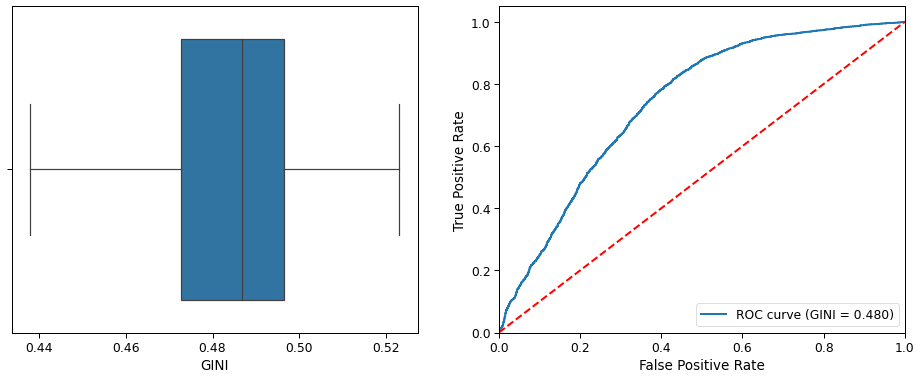

In [8]:
# boxplot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
fig1 = sns.boxplot(scores["test_score"]*2-1, ax=axs[0])
fig1.set_xlabel('GINI')

# RoC
preds = pipe.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw=2
axs[1].plot(fpr, tpr, lw=lw, label='ROC curve (GINI = %0.3f)' % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.savefig('Img\lr_cv_roc.png', facecolor='w')

### Performance vs sample size

In [9]:
n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]
gini_sample = []

for sample_size in n_sample:
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_train.csv"))
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_test.csv"))
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

    X_train = X_train.sample(sample_size, random_state=SEED).copy()
    y_train = y_train.sample(sample_size, random_state=SEED).copy()

    pipe = Pipeline([
        ("encoder", WOEEncoder()),
        ("lr", LogisticRegression())
    ])

    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(pipe, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
    mean_train_auc = scores["train_score"].mean()
    mean_test_auc = scores["test_score"].mean()
    std_test_auc = scores["test_score"].std()

    # Test
    pipe.fit(X = X_train, y = np.ravel(y_train))
    preds = pipe.predict_proba(X_test)[::,1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Print the results
    print(f"Sample size: {sample_size}")
    print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
    print("mean_dev_GINI:\t\t", np.round(mean_test_auc * 2 - 1, 4), f"({np.round(std_test_auc, 4)})")
    print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}\n")
    
    gini_sample.append(test_auc)

Sample size: 50
mean_train_GINI:	 0.9055
mean_dev_GINI:		 0.1907 (0.178)
test_GINI:		 0.1981

Sample size: 100
mean_train_GINI:	 0.8024
mean_dev_GINI:		 0.2904 (0.0948)
test_GINI:		 0.2982

Sample size: 500
mean_train_GINI:	 0.5195
mean_dev_GINI:		 0.3614 (0.0459)
test_GINI:		 0.4083

Sample size: 1000
mean_train_GINI:	 0.5003
mean_dev_GINI:		 0.4171 (0.0351)
test_GINI:		 0.4522

Sample size: 2000
mean_train_GINI:	 0.5117
mean_dev_GINI:		 0.4664 (0.0207)
test_GINI:		 0.4739

Sample size: 3000
mean_train_GINI:	 0.4991
mean_dev_GINI:		 0.4639 (0.0245)
test_GINI:		 0.4745

Sample size: 5000
mean_train_GINI:	 0.4928
mean_dev_GINI:		 0.4746 (0.0159)
test_GINI:		 0.4775

Sample size: 7000
mean_train_GINI:	 0.4927
mean_dev_GINI:		 0.4794 (0.0141)
test_GINI:		 0.4782

Sample size: 10000
mean_train_GINI:	 0.5028
mean_dev_GINI:		 0.4933 (0.0132)
test_GINI:		 0.4796

Sample size: 20000
mean_train_GINI:	 0.489
mean_dev_GINI:		 0.4835 (0.0074)
test_GINI:		 0.4801



In [10]:
n_sample = pd.Series(n_sample, name='Training sample size')
gini_sample = pd.Series(gini_sample, name='GINI')*2-1
res =  pd.concat([n_sample, gini_sample], axis=1)

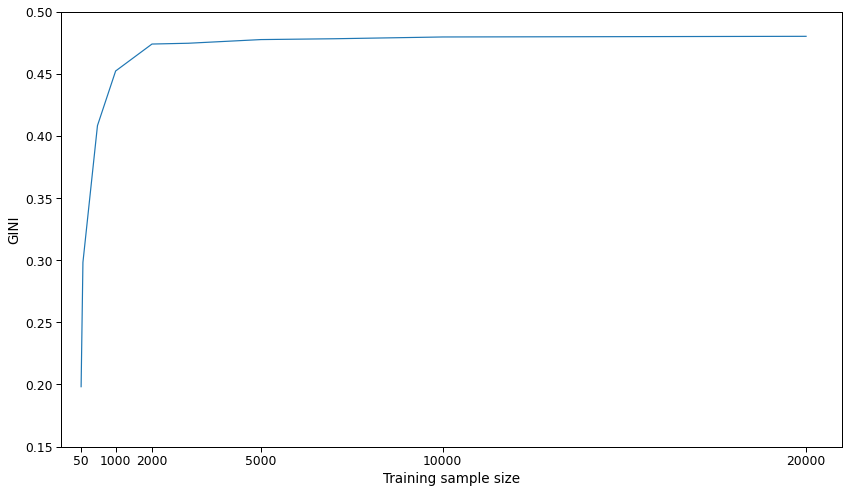

In [11]:
fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(data=res, x='Training sample size', y='GINI')
ax.set_ylim([0.15, 0.5])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [37]:
import joblib

lr_res = {
    'val_scores': scores["test_score"]*2-1,
    'fpr': fpr,
    'tpr': tpr,
    'test_auc': test_auc,
    'n_sample': list(n_sample),
    'gini_sample': list(gini_sample)
}

joblib.dump(lr_res, os.path.join('Experiment results', 'lr_res.pth'))

['Experiment results\\lr_res.pth']

In [27]:
lr_res

{'val_scores': array([0.4758, 0.4954, 0.4833, 0.4628, 0.5045, 0.4746, 0.4874, 0.4804,
        0.4815, 0.4930, 0.4964, 0.4531, 0.5053, 0.4716, 0.4890, 0.4805,
        0.4628, 0.5173, 0.4740, 0.4850, 0.4642, 0.5008, 0.4757, 0.4932,
        0.4801]),
 'fpr': array([0.0000, 0.0000, 0.0000, ..., 0.9982, 0.9982, 1.0000]),
 'tpr': array([0.0000, 0.0001, 0.0018, ..., 0.9996, 1.0000, 1.0000]),
 'gini_sample': 0    0.198135
 1    0.298206
 2    0.408253
 3    0.452214
 4    0.473911
 5    0.474544
 6    0.477501
 7    0.478161
 8    0.479598
 9    0.480122
 Name: GINI, dtype: float64}